# Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns
import umap.umap_ as umap

from IPython.display import Image
from math import ceil
from matplotlib import cm
from plotly import express as px
from scipy.cluster import hierarchy as hc
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from tabulate import tabulate

## Funções de suporte

In [2]:
def jupyter_settings():
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [15, 7]
    plt.rcParams['font.size'] = 16
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
jupyter_settings()

In [3]:
def data_summary(num_attributes):
    # Central tendency - mean, median
    tc1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    tc2 = pd.DataFrame(num_attributes.apply(np.median)).T
    
    # Variability - std, coefficient of variation, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(num_attributes.apply(min)).T
    d2 = pd.DataFrame(num_attributes.apply(max)).T
    d3 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
    d4 = pd.DataFrame(num_attributes.apply(np.std)).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    d7 = d4/tc1# cv
    
    # Concatenate
    s = pd.concat([d1, d2, d3, tc1, tc2, d4, d7, d5, d6]).T.reset_index()
    s.columns = ['columns', 'min', 'max', 'range', 'mean', 'median', 'std', 'cv', 'skew', 'kurtosis']

    return s

In [4]:
def silhouette_plot(X, labels, ax):
    silhouette_avg = silhouette_score(X, labels)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, labels)
    
    y_lower = 10
    k = np.unique(labels).shape[0]
    for j in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster j, and sort them
        jth_cluster_silhouette_values = sample_silhouette_values[labels == j]
        jth_cluster_silhouette_values.sort()
        
        size_cluster_j = jth_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_j
        
        color = cm.nipy_spectral(float(j) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0,
                          jth_cluster_silhouette_values,
                          facecolor=color,
                          edgecolor=color,
                          alpha=0.7)
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))
        
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    ax.set_title(
        'Silhouette score for {} clusters: {:.2f}'.format(k, silhouette_avg),
        fontsize = 12
    )

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([]) # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

## Importar dados

In [7]:
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding = 'latin1')
df_raw.drop('Unnamed: 8', axis = 1, inplace = True)

# 1 Descrição dos dados

In [8]:
df1 = df_raw.copy()

## 1.1 Renomear colunas

In [9]:
cols = ['invoice', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols

In [10]:
df1.columns

Index(['invoice', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

**invoice:** Invoice number (A 6-digit integral number uniquely assigned to each transaction)

**stock_code:** Product (item) code

**description:** Product (item) name

**quantity:** The quantities of each product (item) per transaction

**invoice_date:** The day when each transaction was generated

**unit_price:** Unit price (Product price per unit)

**customer_id:** Customer number (Unique ID assigned to each customer)

**country:** Country name (The name of the country where each customer resides)

## 1.2 Dimensão dos dados

In [11]:
print('Número de linhas: {}'.format(df1.shape[0]))
print('Número de colunas: {}'.format(df1.shape[1]))

Número de linhas: 541909
Número de colunas: 8


## 1.3 Tratar os NAs

In [12]:
df1['description'].fillna('-', inplace = True)

In [13]:
df1.dropna(inplace = True)
# # Criando id únicos para cada fatura não identificada
# df_missing = df1[df1['customer_id'].isna()]
# df_not_missing = df1[~df1['customer_id'].isna()]

# # Criar referência com base no número do invoice
# df_ref = pd.DataFrame(df_missing['invoice'].drop_duplicates())
# df_ref['customer_id'] = np.arange(19000, 19000+len(df_ref), 1)

# # Juntar referência com dataframe original
# df1 = df1.merge(df_ref, how = 'left', on = 'invoice')

# # Coalesce
# df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# # Drop extra id columns
# df1.drop(columns = ['customer_id_x', 'customer_id_y'], inplace = True)

In [14]:
df1.isna().sum()

invoice         0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

In [15]:
print('Dados removidos: {:.1f}%'.format(100*(1-df1.shape[0]/df_raw.shape[0])))

Dados removidos: 24.9%


## 1.4 Tipo dos dados

In [16]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')
df1['customer_id'] = df1['customer_id'].astype(int)

In [17]:
df1.dtypes

invoice                 object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int32
country                 object
dtype: object

## 1.5 Estatística descritiva

In [18]:
num_attributes = df1[['quantity', 'unit_price']]
cat_attributes = df1[['invoice', 'stock_code', 'description', 'customer_id', 'country']]

### 1.5.1 Atributos numéricos

In [19]:
data_summary(num_attributes)

,columns,min,max,range,mean,median,std,cv,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,20.619087,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,20.030532,452.219019,246924.542988


### 1.5.2 Atributos categóricos

In [20]:
cat_attributes.apply(lambda x: x.nunique())

invoice        22190
stock_code      3684
description     3896
customer_id     4372
country           37
dtype: int64

In [21]:
df1[df1['stock_code'].apply(
    lambda x: bool(re.search('^[a-zA-Z]+$', x)))
   ]['stock_code'].unique()

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

# 2 Filtragem das variáveis

## Data checkpoint

In [22]:
df2 = df1.copy()

In [23]:
df2.to_csv('../data/interim/c5_df2.csv', index = False)

In [40]:
df2 = pd.read_csv('../data/interim/c5_df2.csv')
df2['invoice_date'] = pd.to_datetime(df2['invoice_date'])

## 2.1 Stock code

In [24]:
size_of_data = len(df2)

In [25]:
df2.loc[df2['stock_code'].apply(lambda x: x.isalpha()), 'stock_code'].unique()

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

In [26]:
# Remover stock code M, POST, PADS, DOT, CRUK
bad_code = ['M', 'POST', 'PADS', 'DOT', 'CRUK']
bad_code = ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']
df2 = df2[~df2['stock_code'].isin(bad_code)]

## 2.2 Quantity & price

In [27]:
# Remover quantidades negativas dos clientes não identificados
df2 = df2.drop(df2[(df2['quantity'] < 0) & (df2['customer_id'] >= 19000)].index)

In [28]:
# Remover itens com preço zero
df2 = df2[df2['unit_price'] > 0]

## 2.3 Description

In [29]:
df2.loc[df2['description'].apply(lambda x: x.isalpha()), 'description'].unique()

array(['CARRIAGE'], dtype=object)

In [30]:
# Remover description CARRIAGE
df2 = df2[df2['description'] != 'CARRIAGE']

## 2.4 Customer id

In [31]:
# Clientes cujos id só possuem mais registros de devolução do que compra.
bad_customers = [12605, 12666, 12870, 12943, 13693, 
                 13829, 13958, 14119, 14213, 14627, 
                 14679, 14777, 15638, 15728, 16061, 
                 16138, 16252, 16262, 16428, 16579, 
                 16742, 16995, 17307, 17547, 17820, 
                 18141, 18256, 15823, 17548, 16546, 12346, 16446]
df2 = df2[~df2['customer_id'].isin(bad_customers)]

## 2.5 Dados filtrados

In [32]:
print('Dados removidos: {:.1f}%'.format(100*(1-df2.shape[0]/size_of_data)))
print('Número de linhas: {}'.format(df2.shape[0]))

Dados removidos: 0.5%
Número de linhas: 404734


# 3 Feature engineering

## Data checkpoint

In [33]:
df3 = df2.copy()

In [34]:
df3.to_csv('../data/interim/c5_df3.csv', index = False)

In [10]:
df3 = pd.read_csv('../data/interim/c5_df3.csv')
df3['invoice_date'] = pd.to_datetime(df3['invoice_date'])

## 3.1 Criação das variáveis

*Customer*

**customer_id:** customer identification

**country:** customer's country of residence

**vintage:** how many months customer is client

*Revenue*

**revenue:** total amount spend by customer so far

**return:** total value of charge back invoices

**avg_ticket:** average expense of a customer per invoice

**low_purch:** lowest purchase value

**high_purch:** highest purchase value

**monthly_revenue:** monthly expense of a customer

*Frequency*

**invoices:** number of purchases

**monthly_invoices:** number of purchases (invoices) per month

**invoices_return:** number of returns

*Recency*

**recency:** time since last purchase

**mean_recency:** average interval between purchases

*Habits*

**basket_size:** average number of items per purchase

**product_variety:** number of unique products

**low_unit_price:** smallest price of a single product purchased

**high_unit_price:** highest price of a single product purchased

**avg_unit_price:** average price of the products purchased

In [35]:
purchases = df3[~df3['invoice'].str.startswith('C')]
charge_back = df3[df3['invoice'].str.startswith('C')]

In [36]:
# Revenue
purchases['price'] = purchases['quantity']*purchases['unit_price']
charge_back['price'] = charge_back['quantity']*charge_back['unit_price']
df_customer = purchases[['customer_id', 'price']].groupby('customer_id').sum().reset_index().rename(columns = {'price': 'revenue'})

# Return
aux = charge_back[['customer_id', 'price']].groupby('customer_id').sum().reset_index().rename(columns = {'price': 'return'})
df_customer = df_customer.merge(aux, how = 'left', on = 'customer_id')
df_customer['return'].fillna(0, inplace = True)

# Invoices - number of purchases
aux = purchases[['customer_id', 'invoice']].groupby('customer_id').nunique().reset_index().rename(columns = {'invoice': 'invoices'})
df_customer = df_customer.merge(aux, how = 'left', on = 'customer_id')

# Invoices return
aux = charge_back[['customer_id', 'invoice']].groupby('customer_id').nunique().reset_index().rename(columns = {'invoice': 'invoices_return'})
df_customer = df_customer.merge(aux, how = 'left', on = 'customer_id')
df_customer['invoices_return'].fillna(0, inplace = True)

# Last invoice date
aux = purchases[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index().rename(columns = {'invoice_date': 'last_date'})
df_customer = df_customer.merge(aux, how = 'left', on = 'customer_id')

# Recency - days since last purchase
ref_date = df_customer['last_date'].max()
df_customer['recency'] = df_customer['last_date'].apply(lambda x: (ref_date-x).days)

# Average recency
aux = purchases[['customer_id', 'invoice_date']].groupby('customer_id').min().reset_index().rename(columns = {'invoice_date': 'first_purch'})
df_customer = df_customer.merge(aux, how = 'left', on = 'customer_id')
df_customer['avg_recency'] = df_customer.apply(lambda x: (ref_date-x['first_purch']).days/x['invoices'], axis = 1)

# Average ticket
df_purch = purchases[['customer_id', 'invoice', 'price', 'quantity']].groupby(['customer_id', 'invoice']).sum().reset_index()
df_customer['avg_ticket'] = df_purch.groupby('customer_id').mean().reset_index()['price']

# Low purch
df_customer['low_purch'] = df_purch.groupby('customer_id').min().reset_index()['price']

# High purch
df_customer['high_purch'] = df_purch.groupby('customer_id').max().reset_index()['price']

# Mean basket size
df_customer['basket_size'] = df_purch.groupby('customer_id').mean().reset_index()['quantity']

# Country
customers = purchases['customer_id'].unique()
country = []
for customer in customers:
    aux = purchases.loc[purchases['customer_id'] == customer]
    last_date = aux['invoice_date'].max()
    country.append(aux[aux['invoice_date'] == last_date]['country'].iloc[0])
df_country = pd.DataFrame({'customer_id': customers, 'country': country})
df_customer = df_customer.merge(df_country, how = 'left', on = 'customer_id')

C:\Users\lucas\AppData\Local\Temp/ipykernel_63992/2547821566.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchases['price'] = purchases['quantity']*purchases['unit_price']
C:\Users\lucas\AppData\Local\Temp/ipykernel_63992/2547821566.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charge_back['price'] = charge_back['quantity']*charge_back['unit_price']


In [37]:
# Low unit price
auxgroup = df3[['customer_id', 'unit_price']].groupby('customer_id')
aux = auxgroup.min().reset_index().rename(columns = {'unit_price': 'low_unit_price'})
df_customer = df_customer.merge(aux, how = 'left', on = 'customer_id')

# High unit price
aux = auxgroup.max().reset_index().rename(columns = {'unit_price': 'high_unit_price'})
df_customer = df_customer.merge(aux, how = 'left', on = 'customer_id')

# Avg unit price
aux = auxgroup.mean().reset_index().rename(columns = {'unit_price': 'avg_unit_price'})
df_customer = df_customer.merge(aux, how = 'left', on = 'customer_id')

# Product variety
aux = df3[['customer_id', 'stock_code']].groupby('customer_id').nunique().reset_index().rename(columns = {'stock_code': 'product_variety'})
df_customer = df_customer.merge(aux, how = 'left', on = 'customer_id')

# Monthly invoices
df_customer['vintage'] = df_customer.apply(lambda x: (ref_date-x['first_purch']).days/30, axis = 1)
df_customer['vintage'] = df_customer['vintage'].apply(ceil)
df_customer['monthly_invoices'] = df_customer.apply(lambda x: x['invoices'] if x['vintage'] == 0 
                                                    else x['invoices']/x['vintage'], axis = 1)

# Monthly revenue
df_customer['monthly_revenue'] = df_customer.apply(lambda x: x['revenue'] if x['vintage'] == 0 
                                                    else x['revenue']/x['vintage'], axis = 1)

In [38]:
df_customer.isna().sum()

customer_id         0
revenue             0
return              0
invoices            0
invoices_return     0
last_date           0
recency             0
first_purch         0
avg_recency         0
avg_ticket          0
low_purch           0
high_purch          0
basket_size         0
country             0
low_unit_price      0
high_unit_price     0
avg_unit_price      0
product_variety     0
vintage             0
monthly_invoices    0
monthly_revenue     0
dtype: int64

In [39]:
df3 = df_customer.drop(columns = ['last_date', 'first_purch']).copy()

# 4 Análise exploratória de dados

## Data checkpoint

In [40]:
df4 = df3.copy()

In [41]:
df4.to_csv('../data/interim/c5_df4.csv', index = False)

In [37]:
df4 = pd.read_csv('../data/interim/c5_df4.csv')

## 4.1 Análise univariada

In [45]:
data_summary(df4.drop(columns = 'country'))

,columns,min,max,range,mean,median,std,cv,skew,kurtosis
0,customer_id,12347.000000,18287.000000,5940.000000,15298.861663,15296.500000,1721.474140,0.112523,0.003300,-1.195431
1,revenue,3.750000,279138.020000,279134.270000,1966.436513,668.075000,8467.061414,4.305789,20.894452,564.886736
2,return,-22998.400000,0.000000,22998.400000,-51.662654,0.000000,501.882393,-9.714607,-30.999833,1215.144069
3,invoices,1.000000,206.000000,205.000000,4.250808,2.000000,7.641379,1.797630,11.937896,243.606600
4,invoices_return,0.000000,45.000000,45.000000,0.772979,0.000000,1.971379,2.550365,9.179281,151.665158
5,recency,0.000000,373.000000,373.000000,92.057275,50.000000,100.019993,1.086497,1.246534,0.432431
6,avg_recency,0.000000,373.000000,373.000000,98.542173,67.000000,87.681121,0.889783,1.451463,1.391526
7,avg_ticket,3.750000,14844.766667,14841.016667,379.892452,290.251273,510.526508,1.343871,12.924979,283.103064
8,low_purch,0.380000,9341.260000,9340.880000,247.280148,169.850000,362.456631,1.465773,10.342791,181.974785
9,high_purch,3.750000,38970.000000,38966.250000,592.437838,364.810000,1297.184179,2.189570,15.695052,340.808592


In [46]:
df4.quantile([0, .25, .5, .75, .9, .95, .99, 1])

,customer_id,revenue,return,invoices,invoices_return,recency,avg_recency,avg_ticket,low_purch,high_purch,basket_size,low_unit_price,high_unit_price,avg_unit_price,product_variety,vintage,monthly_invoices,monthly_revenue
0.00,12347.00,3.7500,-22998.400,1.0,0.00,0.00,0.000,3.750000,0.3800,3.7500,1.000000,0.001,0.17,0.122500,1.00,0.0,0.076923,0.375000
0.25,13812.25,305.5600,-14.705,1.0,0.00,17.00,36.925,178.149167,95.8125,219.9075,93.500000,0.210,7.95,2.165425,16.00,4.0,0.222222,50.007083
0.50,15296.50,668.0750,0.000,2.0,0.00,50.00,67.000,290.251273,169.8500,364.8100,162.000000,0.390,12.50,2.837629,35.00,9.0,0.400000,115.330682
0.75,16778.75,1630.6650,0.000,5.0,1.00,141.75,128.500,425.316667,307.8150,612.7675,272.458333,0.650,14.95,3.723579,77.75,11.0,0.710714,250.635000
0.90,17686.40,3566.0680,0.000,9.0,2.00,262.10,245.000,659.496000,457.4980,1049.1490,422.050000,1.250,19.95,4.902339,143.00,13.0,1.000000,465.958519
0.95,17984.55,5722.9275,0.000,13.0,4.00,311.00,303.000,916.508500,653.0635,1508.4430,600.000000,1.650,39.95,6.045543,204.00,13.0,1.600000,696.497115
0.99,18225.71,17587.6979,0.000,30.0,7.71,368.00,368.000,2005.950000,1434.5986,3884.2809,1343.040000,4.950,125.00,10.950000,353.71,13.0,3.000000,1957.166014
1.00,18287.00,279138.0200,0.000,206.0,45.00,373.00,373.000,14844.766667,9341.2600,38970.0000,7824.000000,295.000,649.50,327.225000,1791.00,13.0,15.846154,23261.501667


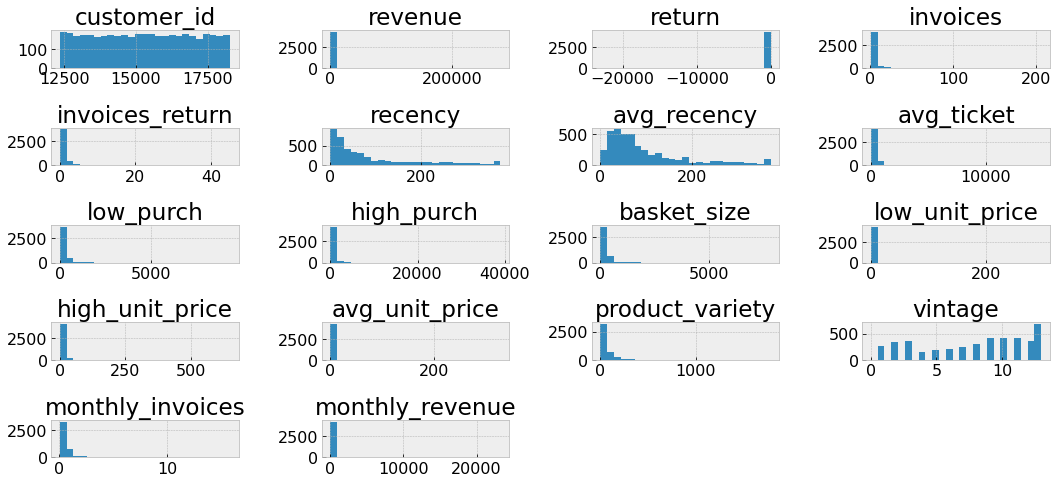

In [47]:
df4.hist(bins = 25);
plt.tight_layout()

### 4.1.1 Monthly revenue

In [48]:
print('Quantiles:')
print(df4['monthly_revenue'].quantile([0, .25, .5, .75, .9, .95, .99, 1]))
print('\nMax values:')
df4[['customer_id', 'monthly_revenue']].sort_values('monthly_revenue').tail()

Quantiles:
0.00        0.375000
0.25       50.007083
0.50      115.330682
0.75      250.635000
0.90      465.958519
0.95      696.497115
0.99     1957.166014
1.00    23261.501667
Name: monthly_revenue, dtype: float64

Max values:


,customer_id,monthly_revenue
2675,16000,12393.700000
1288,14096,13314.607500
3722,17450,14965.445385
4193,18102,19973.638462
1688,14646,23261.501667


<AxesSubplot:>

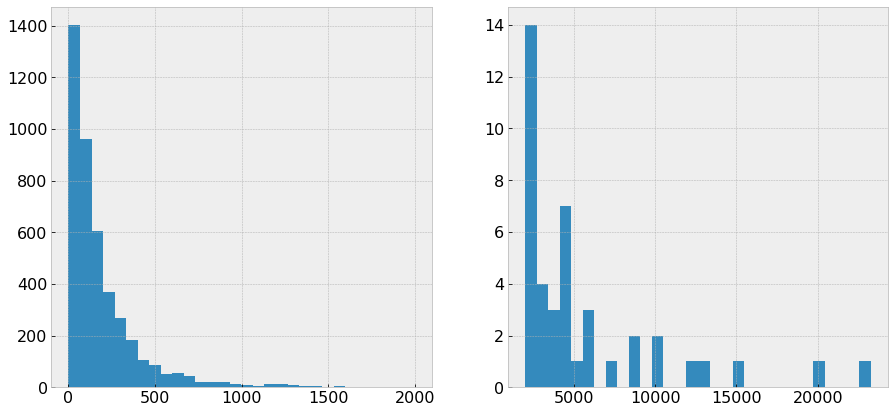

In [49]:
plt.subplot(121)
df4[df4['monthly_revenue'] < 2000]['monthly_revenue'].hist(bins = 30)

plt.subplot(122)
df4[df4['monthly_revenue'] >= 2000]['monthly_revenue'].hist(bins = 30)

In [50]:
df4[df4['monthly_revenue'] == df4['monthly_revenue'].max()]

,customer_id,revenue,return,invoices,invoices_return,recency,avg_recency,avg_ticket,low_purch,high_purch,basket_size,country,low_unit_price,high_unit_price,avg_unit_price,product_variety,vintage,monthly_invoices,monthly_revenue
1688,14646,279138.02,-360.0,72,1.0,1,4.916667,3876.916944,2.08,20277.92,2733.944444,Netherlands,0.19,110.0,2.393594,699,12,6.0,23261.501667


### 4.1.2 Monthly invoices

In [51]:
print('Quantiles:')
print(df4['monthly_invoices'].quantile([0, .25, .5, .75, .9, .95, .99, 1]))
print('\nMax values:')
df4[['customer_id', 'monthly_invoices']].sort_values('monthly_invoices').tail()

Quantiles:
0.00     0.076923
0.25     0.222222
0.50     0.400000
0.75     0.710714
0.90     1.000000
0.95     1.600000
0.99     3.000000
1.00    15.846154
Name: monthly_invoices, dtype: float64

Max values:


,customer_id,monthly_invoices
1660,14606,7.000000
561,13089,7.461538
4003,17841,9.538462
1878,14911,15.230769
325,12748,15.846154


<AxesSubplot:>

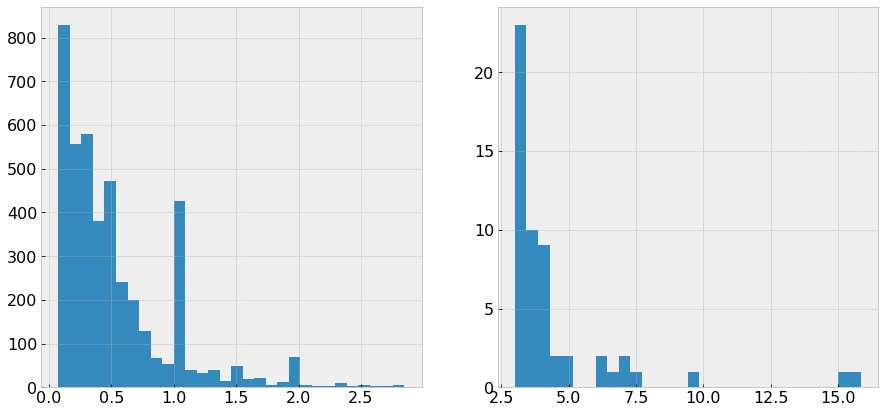

In [52]:
# df4['monthly_invoices'].hist(bins = 30)
plt.subplot(121)
df4[df4['monthly_invoices'] < 3]['monthly_invoices'].hist(bins = 30)

plt.subplot(122)
df4[df4['monthly_invoices'] >= 3]['monthly_invoices'].hist(bins = 30)

In [53]:
df4[df4['monthly_invoices'] > 15]

,customer_id,revenue,return,invoices,invoices_return,recency,avg_recency,avg_ticket,low_purch,high_purch,basket_size,country,low_unit_price,high_unit_price,avg_unit_price,product_variety,vintage,monthly_invoices,monthly_revenue
325,12748,32317.32,-1830.79,206,11.0,0,1.810680,156.880194,0.95,2026.7,123.839806,United Kingdom,0.04,29.95,2.373651,1767,13,15.846154,2485.947692
1878,14911,136275.72,-7393.59,198,44.0,1,1.883838,688.261212,1.45,4345.1,404.944444,EIRE,0.04,165.00,3.381943,1791,13,15.230769,10482.747692


### 4.1.3 Avg ticket

In [54]:
print('Quantiles:')
print(df4['avg_ticket'].quantile([0, .25, .5, .75, .9, .95, .99, 1]))
print('\nMax values:')
df4[['customer_id', 'avg_ticket']].sort_values('avg_ticket').tail()

Quantiles:
0.00        3.750000
0.25      178.149167
0.50      290.251273
0.75      425.316667
0.90      659.496000
0.95      916.508500
0.99     2005.950000
1.00    14844.766667
Name: avg_ticket, dtype: float64

Max values:


,customer_id,avg_ticket
9,12357,6207.670000
54,12415,6228.226500
195,12590,9341.260000
2010,15098,13305.500000
2501,15749,14844.766667


<AxesSubplot:>

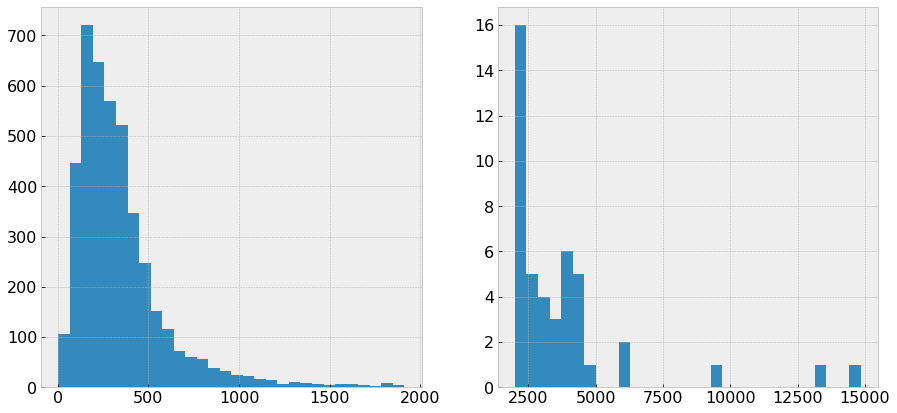

In [55]:
# df4['avg_ticket'].hist(bins = 30)
plt.subplot(121)
df4[df4['avg_ticket'] < 2000]['avg_ticket'].hist(bins = 30)

plt.subplot(122)
df4[df4['avg_ticket'] >= 2000]['avg_ticket'].hist(bins = 30)

In [56]:
df4[df4['avg_ticket'] > 5000]

,customer_id,revenue,return,invoices,invoices_return,recency,avg_recency,avg_ticket,low_purch,high_purch,basket_size,country,low_unit_price,high_unit_price,avg_unit_price,product_variety,vintage,monthly_invoices,monthly_revenue
9,12357,6207.67,0.00,1,0.0,33,33.000000,6207.670000,6207.67,6207.67,2708.000000,Switzerland,0.39,25.00,3.348626,131,2,0.500000,3103.835000
54,12415,124564.53,-926.35,20,4.0,24,16.850000,6228.226500,61.20,22775.93,3868.650000,Australia,0.19,14.95,2.438101,443,12,1.666667,10380.377500
195,12590,9341.26,-2.88,1,1.0,211,211.000000,9341.260000,9341.26,9341.26,4282.000000,Germany,0.65,7.65,2.835652,67,8,0.125000,1167.657500
2010,15098,39916.50,-297.00,3,1.0,182,60.666667,13305.500000,297.00,38970.00,40.333333,United Kingdom,4.95,649.50,327.225000,1,7,0.428571,5702.357143
2501,15749,44534.30,-22998.40,3,1.0,235,110.666667,14844.766667,7837.50,21535.90,6009.333333,United Kingdom,1.69,6.75,3.082667,6,12,0.250000,3711.191667


### 4.1.4 Basket size

In [57]:
print('Quantiles:')
print(df4['basket_size'].quantile([0, .25, .5, .75, .9, .95, .99, 1]))
print('\nMax values:')
df4[['customer_id', 'basket_size']].sort_values('basket_size').tail()

Quantiles:
0.00       1.000000
0.25      93.500000
0.50     162.000000
0.75     272.458333
0.90     422.050000
0.95     600.000000
0.99    1343.040000
1.00    7824.000000
Name: basket_size, dtype: float64

Max values:


,customer_id,basket_size
3224,16754,4280.000000
195,12590,4282.000000
596,13135,4300.000000
2501,15749,6009.333333
4306,18251,7824.000000


<AxesSubplot:>

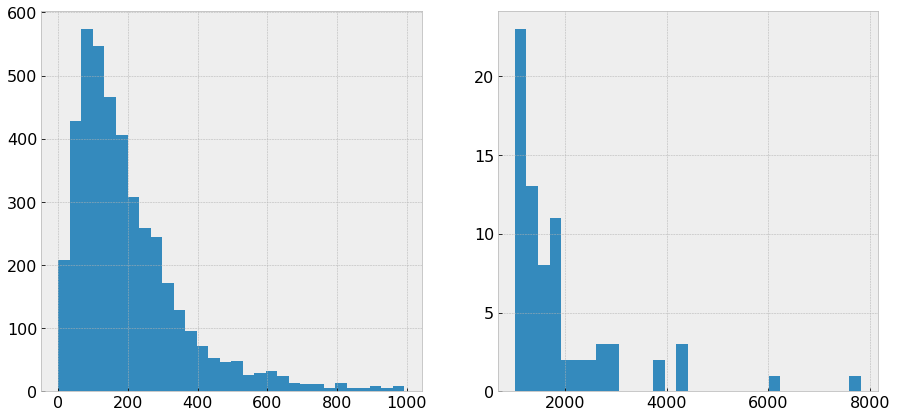

In [58]:
# df4['avg_ticket'].hist(bins = 30)
plt.subplot(121)
df4[df4['basket_size'] < 1000]['basket_size'].hist(bins = 30)

plt.subplot(122)
df4[df4['basket_size'] >= 1000]['basket_size'].hist(bins = 30)

In [59]:
df4[df4['basket_size'] > 4000]

,customer_id,revenue,return,invoices,invoices_return,recency,avg_recency,avg_ticket,low_purch,high_purch,basket_size,country,low_unit_price,high_unit_price,avg_unit_price,product_variety,vintage,monthly_invoices,monthly_revenue
195,12590,9341.26,-2.88,1,1.0,211,211.000000,9341.260000,9341.26,9341.26,4282.000000,Germany,0.65,7.65,2.835652,67,8,0.125000,1167.657500
596,13135,3096.00,0.00,1,0.0,196,196.000000,3096.000000,3096.00,3096.00,4300.000000,United Kingdom,0.72,0.72,0.720000,1,7,0.142857,442.285714
2501,15749,44534.30,-22998.40,3,1.0,235,110.666667,14844.766667,7837.50,21535.90,6009.333333,United Kingdom,1.69,6.75,3.082667,6,12,0.250000,3711.191667
3224,16754,2002.40,0.00,1,0.0,372,372.000000,2002.400000,2002.40,2002.40,4280.000000,United Kingdom,0.18,1.06,0.620000,2,13,0.076923,154.030769
4306,18251,4314.72,0.00,1,0.0,87,87.000000,4314.720000,4314.72,4314.72,7824.000000,United Kingdom,0.32,4.25,0.771875,16,3,0.333333,1438.240000


### 4.1.5 Country

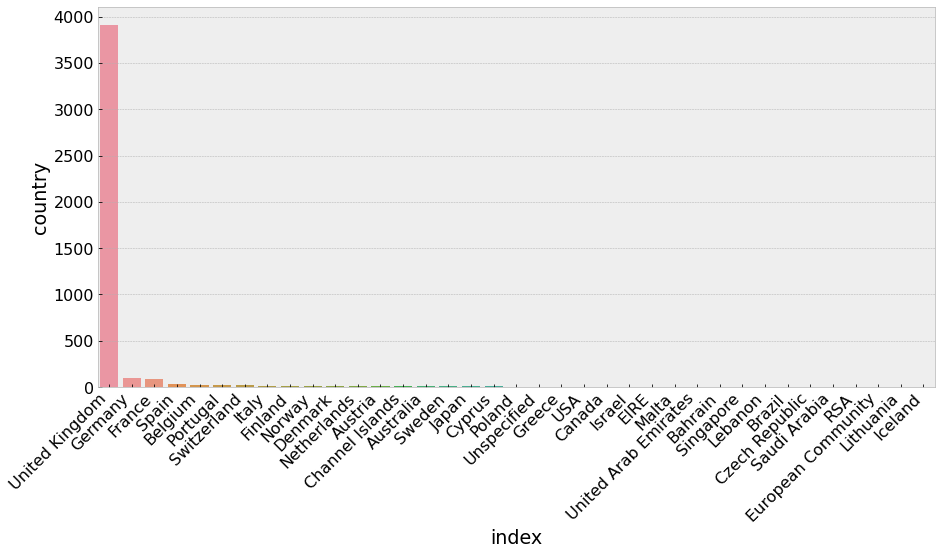

In [60]:
aux = df4['country'].value_counts().reset_index()
sns.barplot(data = aux, x = 'index', y = 'country')
plt.xticks(rotation = 45, horizontalalignment = 'right');

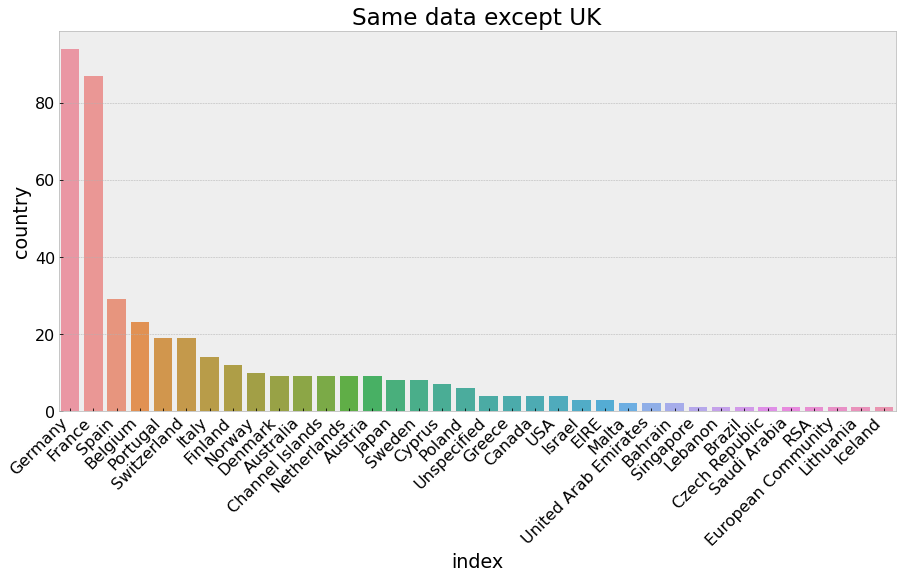

In [61]:
aux = df4[df4['country'] != 'United Kingdom']['country'].value_counts().reset_index()
sns.barplot(data = aux, x = 'index', y = 'country')
plt.xticks(rotation = 45, horizontalalignment = 'right')
plt.title('Same data except UK');

In [62]:
df4['country'].value_counts(normalize = True)

United Kingdom          0.903464
Germany                 0.021709
France                  0.020092
Spain                   0.006697
Belgium                 0.005312
Portugal                0.004388
Switzerland             0.004388
Italy                   0.003233
Finland                 0.002771
Norway                  0.002309
Denmark                 0.002079
Netherlands             0.002079
Austria                 0.002079
Channel Islands         0.002079
Australia               0.002079
Sweden                  0.001848
Japan                   0.001848
Cyprus                  0.001617
Poland                  0.001386
Unspecified             0.000924
Greece                  0.000924
USA                     0.000924
Canada                  0.000924
Israel                  0.000693
EIRE                    0.000693
Malta                   0.000462
United Arab Emirates    0.000462
Bahrain                 0.000462
Singapore               0.000231
Lebanon                 0.000231
Brazil    

## 4.2 Análise bivariada

<Figure size 1440x720 with 0 Axes>

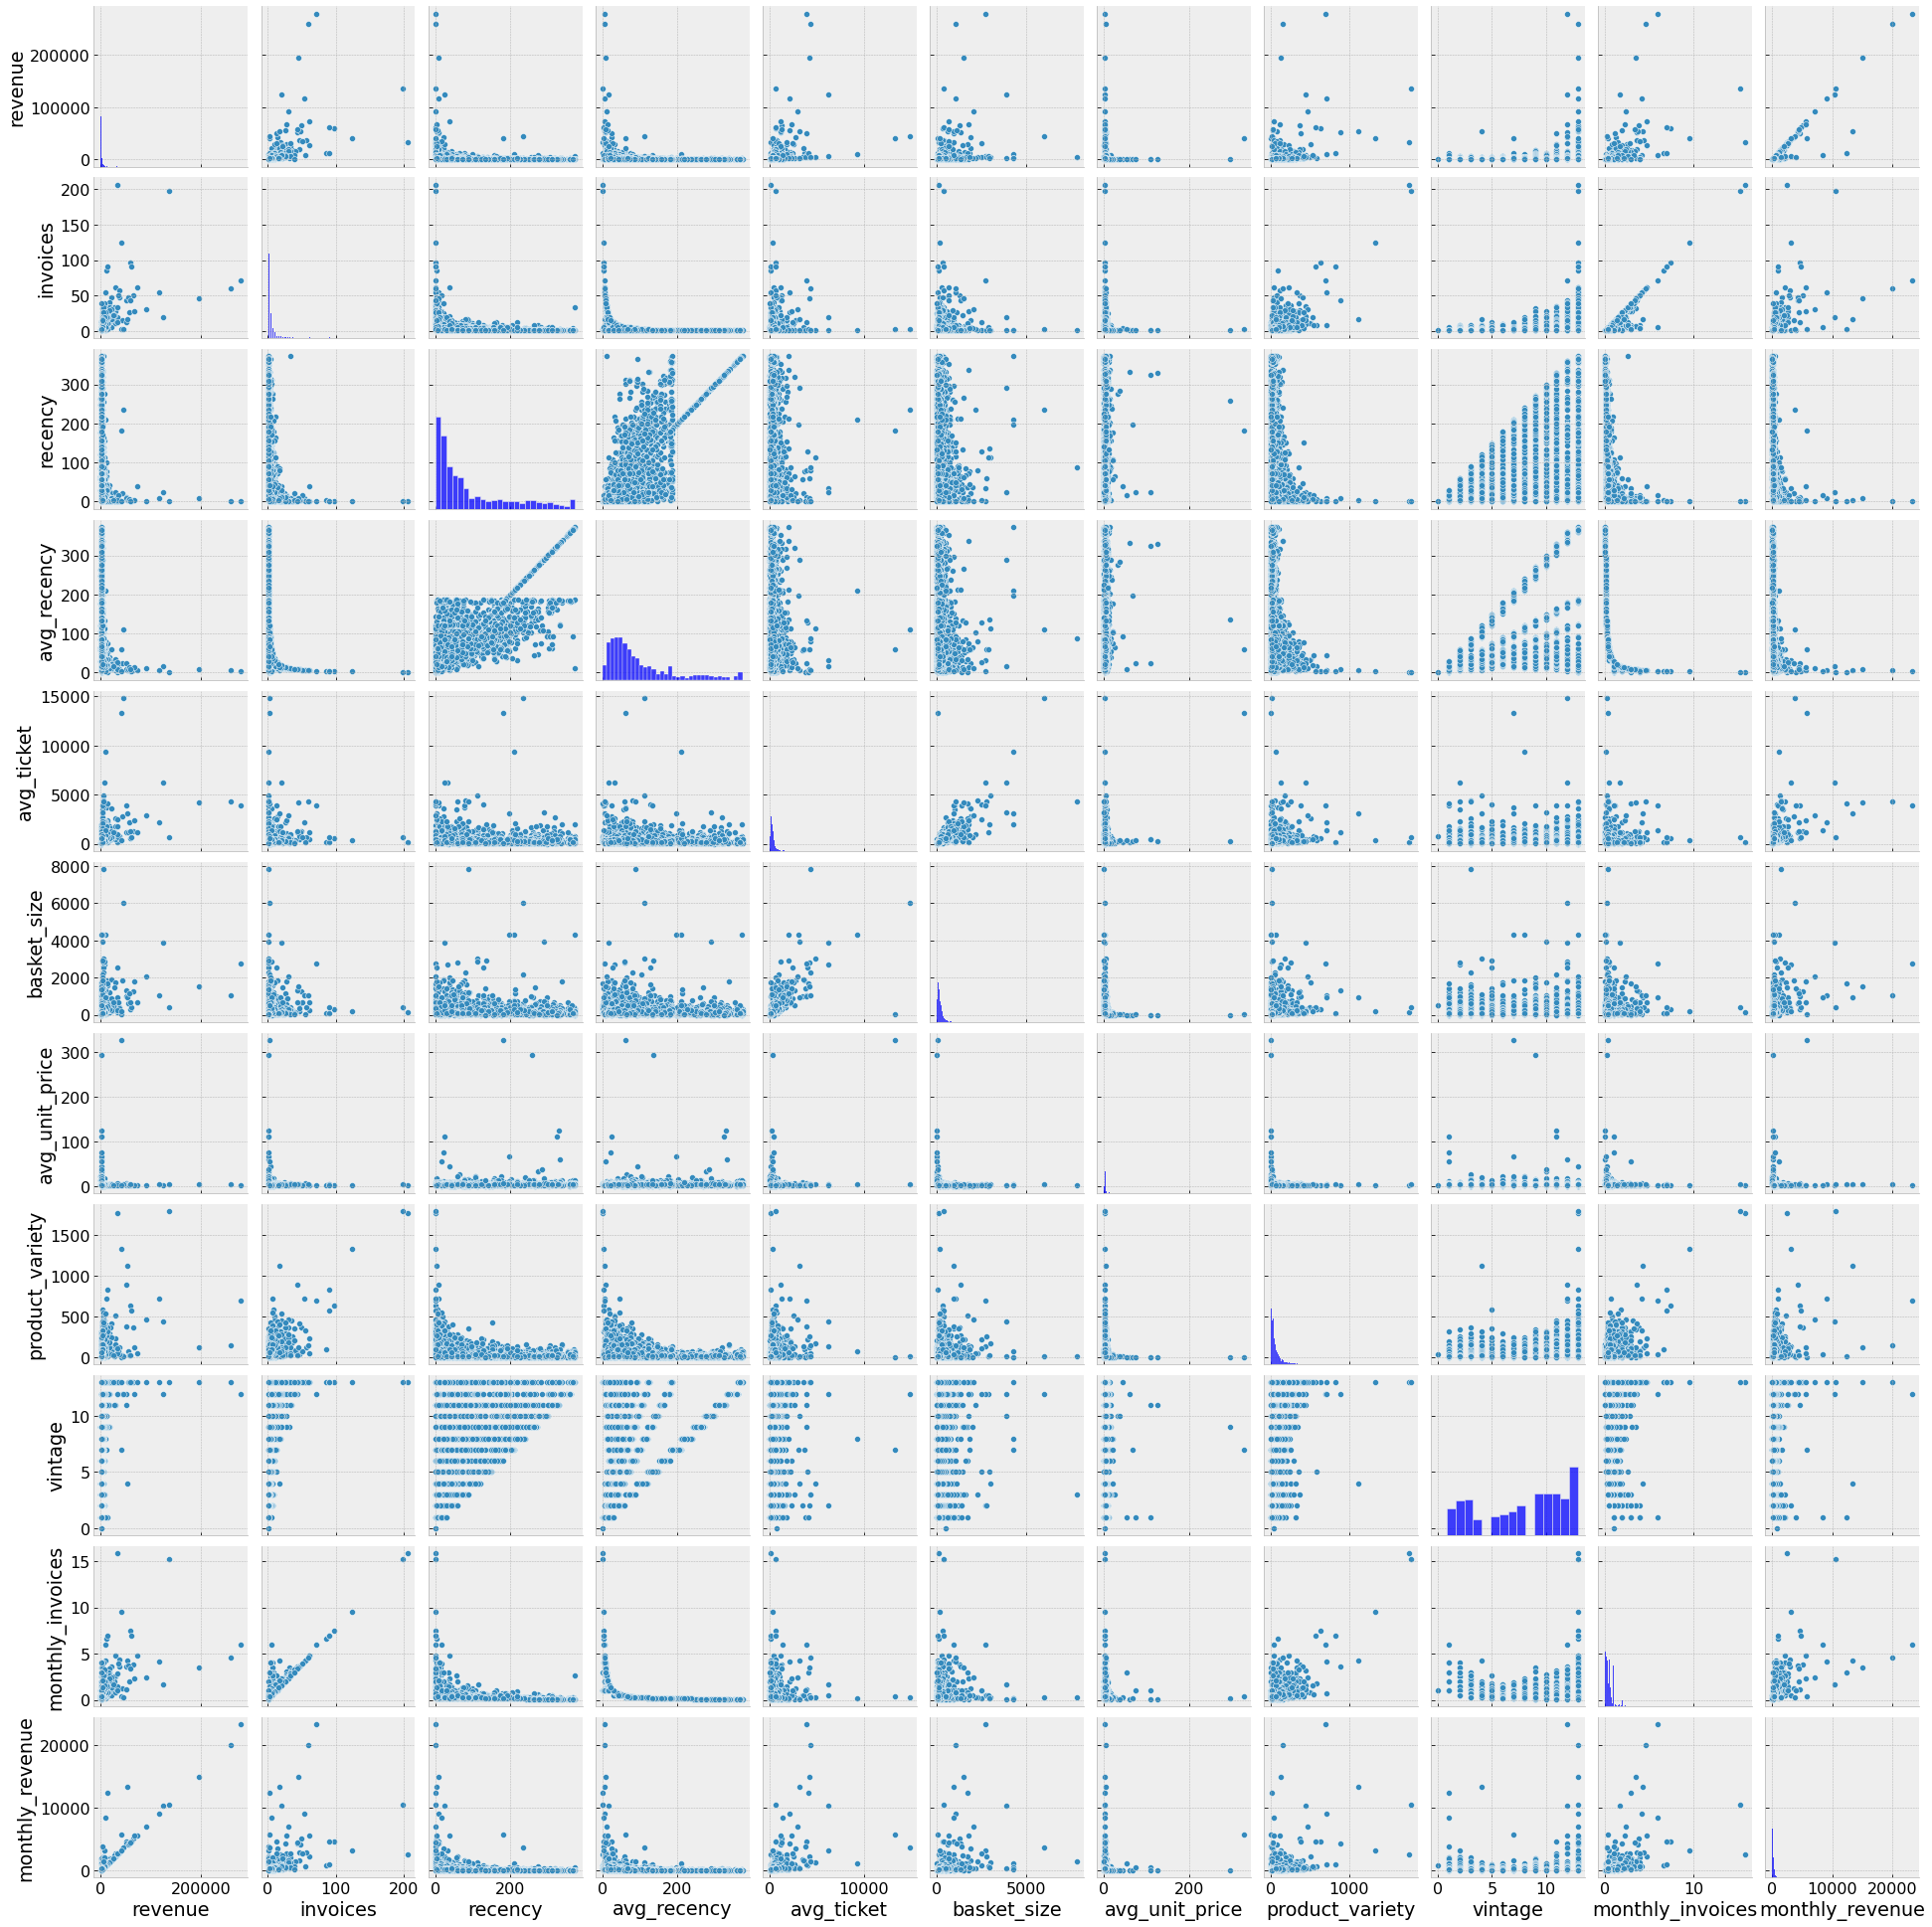

In [63]:
plt.figure(figsize = (20, 10))
drop_cols = ['customer_id', 'return', 'invoices_return', 'low_purch', 'high_purch', 'low_unit_price', 'high_unit_price', 'country']
sns.pairplot(df4.drop(columns = drop_cols))

## 4.3 Análise multivariada

<AxesSubplot:>

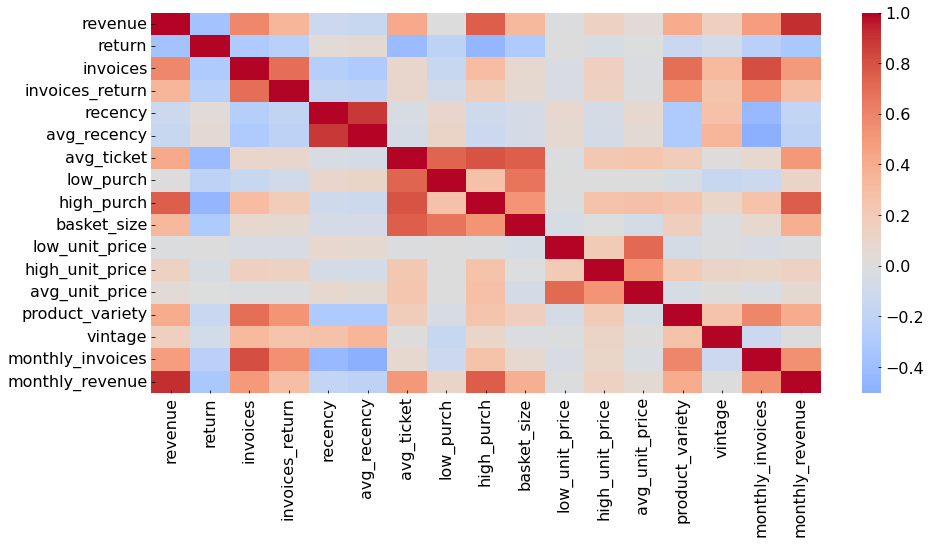

In [64]:
correlation = df4.drop(columns = ['customer_id', 'country']).corr(method = 'pearson')
sns.heatmap(correlation, 
#             annot = True, 
            cmap = 'coolwarm', center = 0)

# 5 Preparação dos dados

## Data checkpoint

In [65]:
df5 = df4.copy()

In [66]:
df5.to_csv('../data/interim/c5_df5.csv', index = False)

In [5]:
df5 = pd.read_csv('../data/interim/c5_df5.csv')

## 5.1 Normalização

*Sem normalizações*

## 5.2 Rescaling

In [6]:
mms = MinMaxScaler()

# revenue
df5['revenue'] = mms.fit_transform(df5[['revenue']].values)
pickle.dump(mms, open('../src/api/features/revenue_scaler.pkl', 'wb'))

# return
df5['return'] = mms.fit_transform(df5[['return']].values)
pickle.dump(mms, open('../src/api/features/return_scaler.pkl', 'wb'))

# invoices
df5['invoices'] = mms.fit_transform(df5[['invoices']].values)
pickle.dump(mms, open('../src/api/features/invoices_scaler.pkl', 'wb'))

# invoices_return
df5['invoices_return'] = mms.fit_transform(df5[['invoices_return']].values)
pickle.dump(mms, open('../src/api/features/invoices_return_scaler.pkl', 'wb'))

# recency
df5['recency'] = mms.fit_transform(df5[['recency']].values)
pickle.dump(mms, open('../src/api/features/recency_scaler.pkl', 'wb'))

# avg_recency
df5['avg_recency'] = mms.fit_transform(df5[['avg_recency']].values)
pickle.dump(mms, open('../src/api/features/avg_recency_scaler.pkl', 'wb'))

# avg_ticket
df5['avg_ticket'] = mms.fit_transform(df5[['avg_ticket']].values)
pickle.dump(mms, open('../src/api/features/avg_ticket_scaler.pkl', 'wb'))

# low_purch
df5['low_purch'] = mms.fit_transform(df5[['low_purch']].values)
pickle.dump(mms, open('../src/api/features/low_purch_scaler.pkl', 'wb'))

# high_purch
df5['high_purch'] = mms.fit_transform(df5[['high_purch']].values)
pickle.dump(mms, open('../src/api/features/high_purch_scaler.pkl', 'wb'))

# basket_size
df5['basket_size'] = mms.fit_transform(df5[['basket_size']].values)
pickle.dump(mms, open('../src/api/features/basket_size_scaler.pkl', 'wb'))

# low_unit_price
df5['low_unit_price'] = mms.fit_transform(df5[['low_unit_price']].values)
pickle.dump(mms, open('../src/api/features/low_unit_price_scaler.pkl', 'wb'))

# high_unit_price
df5['high_unit_price'] = mms.fit_transform(df5[['high_unit_price']].values)
pickle.dump(mms, open('../src/api/features/high_unit_price_scaler.pkl', 'wb'))

# avg_unit_price
df5['avg_unit_price'] = mms.fit_transform(df5[['avg_unit_price']].values)
pickle.dump(mms, open('../src/api/features/avg_unit_price_scaler.pkl', 'wb'))

# product_variety
df5['product_variety'] = mms.fit_transform(df5[['product_variety']].values)
pickle.dump(mms, open('../src/api/features/product_variety_scaler.pkl', 'wb'))

# vintage
df5['vintage'] = mms.fit_transform(df5[['vintage']].values)
pickle.dump(mms, open('../src/api/features/vintage_scaler.pkl', 'wb'))

# monthly_invoices
df5['monthly_invoices'] = mms.fit_transform(df5[['monthly_invoices']].values)
pickle.dump(mms, open('../src/api/features/monthly_invoices_scaler.pkl', 'wb'))

# monthly_revenue
df5['monthly_revenue'] = mms.fit_transform(df5[['monthly_revenue']].values)
pickle.dump(mms, open('../src/api/features/monthly_revenue_scaler.pkl', 'wb'))

## 5.3 Transformação

In [7]:
# country - label encoding
le = LabelEncoder()
df5['country'] = le.fit_transform(df5['country'])
pickle.dump(le, open('../src/api/features/country_encoder.pkl', 'wb'))

# 6 Seleção das features

In [8]:
selected_features = ['customer_id', 'revenue', 'invoices', 'invoices_return', 
                     'recency', 'avg_recency', 'avg_ticket', 'basket_size', 
                     'vintage', 'monthly_invoices', 'monthly_revenue']
df6 = df5[selected_features].copy()

## 6.1 Espaços embedding

In [9]:
X = df6.drop(columns = 'customer_id').copy()

### 6.1.1 PCA

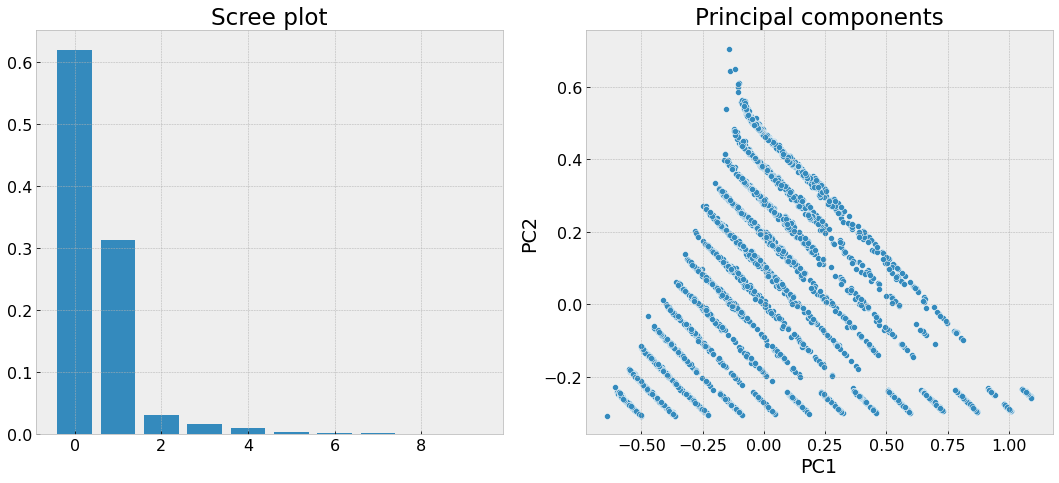

In [62]:
fig, axs = plt.subplots(1, 2)

pca = PCA(n_components = X.shape[1])
principal_components = pca.fit_transform(X)
features = range(pca.n_components_)
df_pca = pd.DataFrame(principal_components)
axs[0].bar(features, pca.explained_variance_ratio_)
axs[0].set_title('Scree plot')

sns.scatterplot(data = df_pca, x = 0, y = 1, ax = axs[1])
axs[1].set_title('Principal components')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')

fig.tight_layout()

### 6.1.2 UMAP

<AxesSubplot:xlabel='0', ylabel='1'>

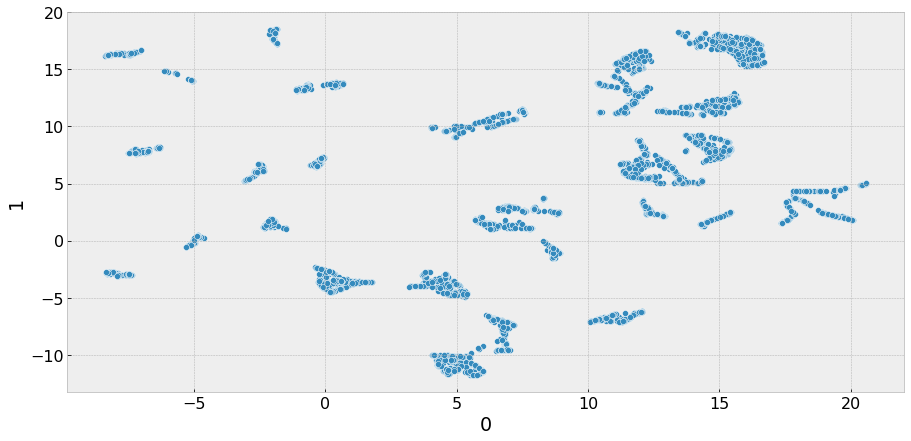

In [10]:
reducer = umap.UMAP(random_state = 73)
embedding = reducer.fit_transform(X)

df_umap = pd.DataFrame(embedding)

sns.scatterplot(data = df_umap, x = 0, y = 1)

### 6.1.3 t-SNE

C:\Users\Adm\anaconda3\envs\loyalty\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Adm\anaconda3\envs\loyalty\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

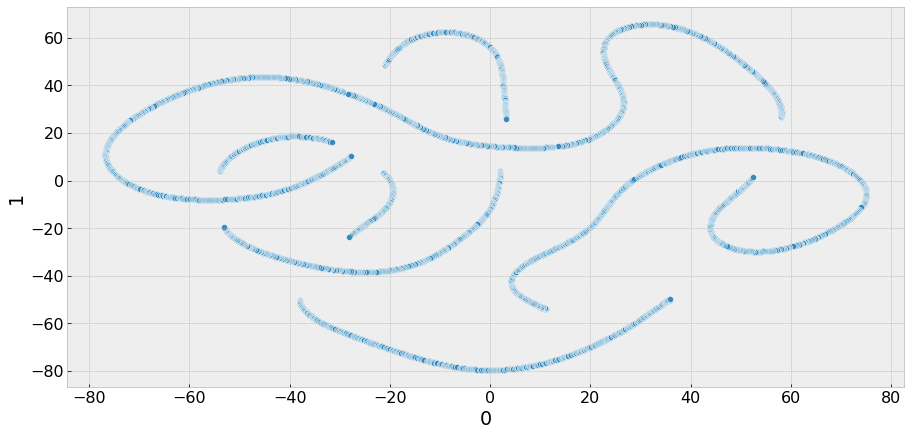

In [18]:
reducer = TSNE(n_components = 2, n_jobs = -1, random_state = 73)
embedding = reducer.fit_transform(X)

df_tsne = pd.DataFrame(embedding)

sns.scatterplot(data = df_tsne, x = 0, y = 1)

### 6.1.4 Árvore

In [19]:
# Dataset
x = X.drop(columns = ['customer_id', 'monthly_revenue'])
y = X['monthly_revenue']

# Model
rf = RandomForestRegressor(random_state = 73)

# Training
rf.fit(x, y)

# Leaves dataframe
df_leaves = pd.DataFrame(rf.apply(x))

C:\Users\Adm\anaconda3\envs\loyalty\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

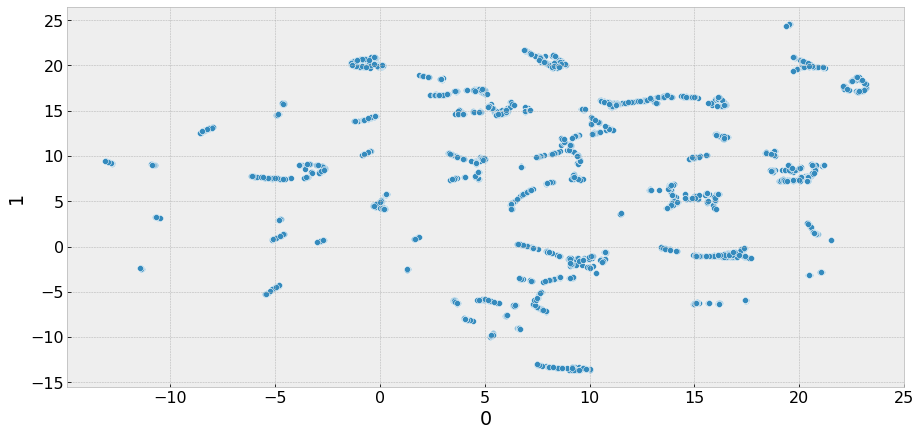

In [20]:
reducer = umap.UMAP(random_state = 73)
embedding = reducer.fit_transform(df_leaves)

df_umap = pd.DataFrame(embedding)

sns.scatterplot(data = df_umap, x = 0, y = 1)

# 7 Ajuste fino dos hyperparâmetros

## Data checkpoint

In [11]:
df7 = df_umap.copy()
X = df7.copy()

## 7.1 K-means

In [19]:
# clusters = range(15, 26)
clusters = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
kmeans_wss = []# Within-cluster sum of squares
kmeans_ss = []# Silhouette score
# fig, axs = plt.subplots(4, 3, figsize = (15, 15))
for k in clusters:
    # Model
    kmeans_model = KMeans(init = 'random',
                          n_clusters = k,
                          max_iter = 300,
                          random_state = 73)
    
    # Training
    kmeans_model.fit(X)
    
    # Predict
    labels = kmeans_model.predict(X)
    
    # Performance
    kmeans_wss.append(kmeans_model.inertia_)
    kmeans_ss.append(silhouette_score(X, labels, metric='euclidean'))
    
#     # Silhouette analysis
#     r, c = divmod(clusters.index(k), 3)# 3 colunas no array axs
#     silhouette_plot(X, labels, axs[r][c])
# fig.tight_layout()

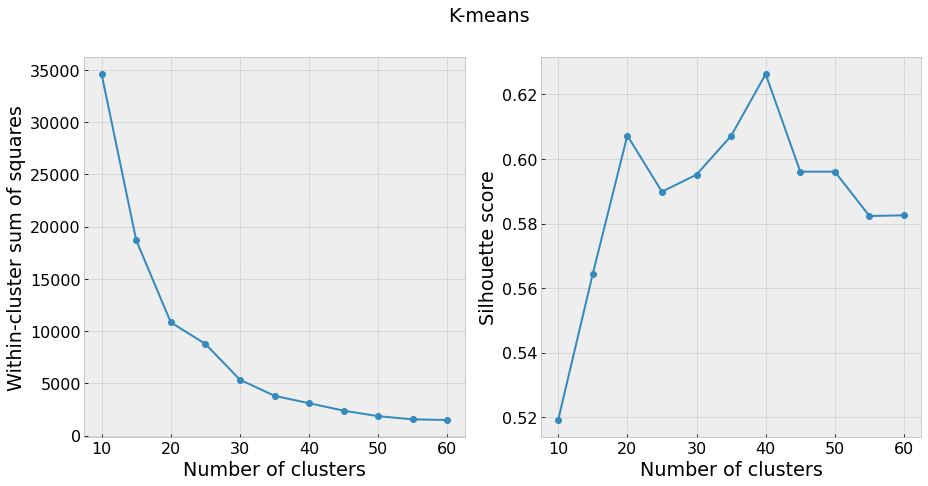

In [20]:
plt.suptitle('K-means')

plt.subplot(1,2,1)
plt.plot(clusters, kmeans_wss, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster sum of squares')

plt.subplot(1,2,2)
plt.plot(clusters, kmeans_ss, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score');

## 7.2 GMM

In [21]:
clusters = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
gmm_ss = []# Silhouette score
# fig, axs = plt.subplots(4, 3, figsize = (15, 15))
for k in clusters:
    # Model
    gmm_model = GaussianMixture(n_components = k,
                                random_state = 73)
    
    # Training
    gmm_model.fit(X)
    
    # Predict
    labels = gmm_model.predict(X)
    
    # Performance
    gmm_ss.append(silhouette_score(X, labels, metric='euclidean'))
    
#     # Silhouette analysis
#     r, c = divmod(clusters.index(k), 3)# 3 colunas no array axs
#     silhouette_plot(X, labels, axs[r][c])
# fig.tight_layout()

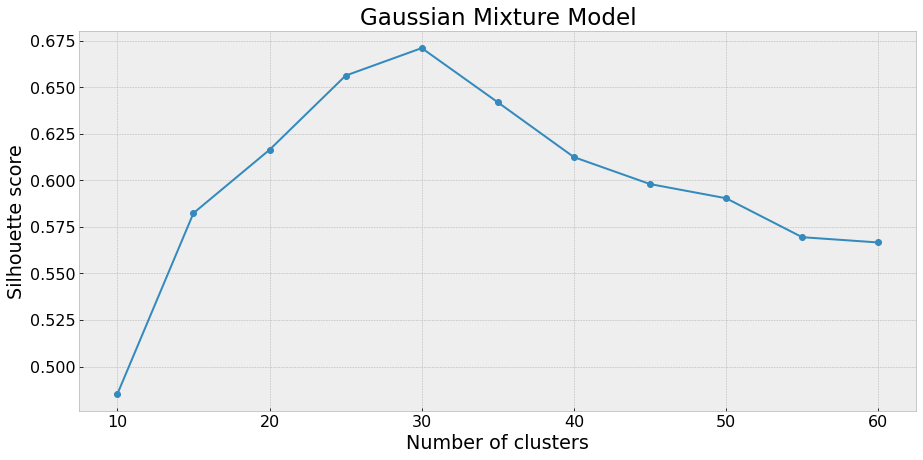

In [22]:
plt.title('Gaussian Mixture Model')

plt.plot(clusters, gmm_ss, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score');

## 7.3 Hierarchical Clustering

In [23]:
hc_model = hc.linkage(X, 'ward')

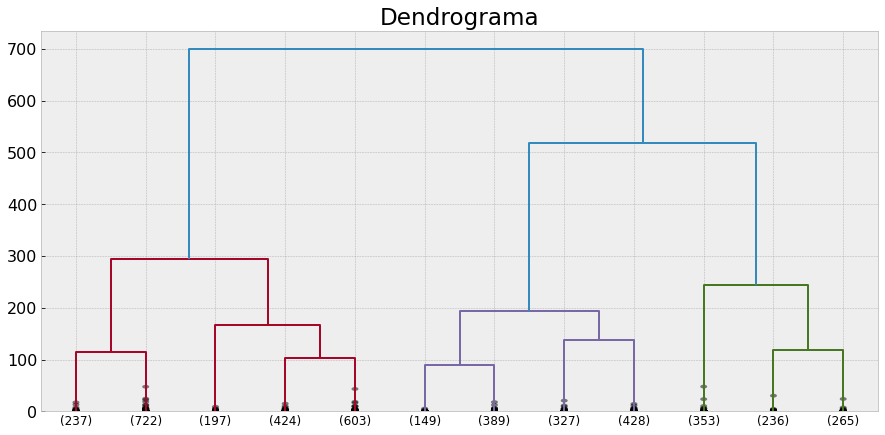

In [24]:
hc.dendrogram(hc_model, 
              truncate_mode = 'lastp', 
              p = 12, 
              show_contracted = True)
plt.plot()
plt.title('Dendrograma');

In [25]:
# clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
clusters = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
hc_ss = []# Silhouette score
# fig, axs = plt.subplots(4, 3, figsize = (15, 15))
for k in clusters:
    # Predict
    labels = hc.fcluster(hc_model, k, criterion = 'maxclust')
    
    # Performance
    hc_ss.append(silhouette_score(X, labels, metric='euclidean'))
    
#     # Silhouette analysis
#     r, c = divmod(clusters.index(k), 3)# 3 colunas no array axs
#     silhouette_plot(X, labels, axs[r][c])
# fig.tight_layout()

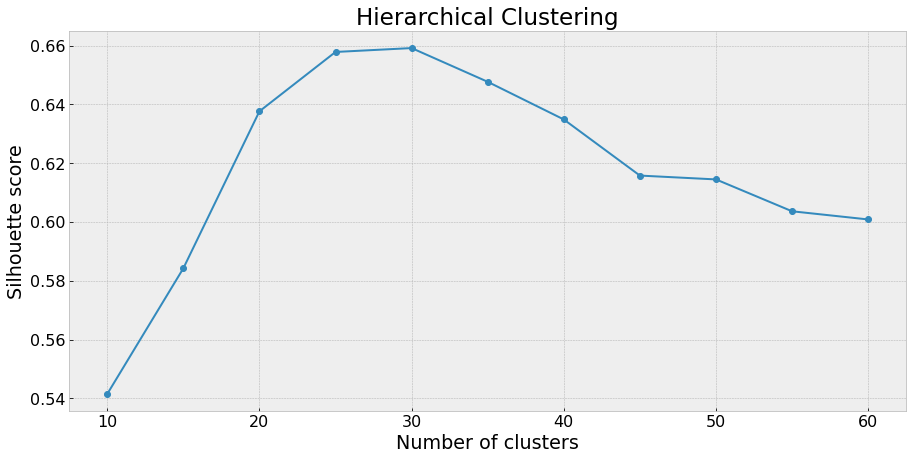

In [26]:
plt.title('Hierarchical Clustering')

plt.plot(clusters, hc_ss, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score');

## 7.4 DBSCAN

In [17]:
eps = .5
min_samples = 20

# Model
dbscan_model = DBSCAN(eps = eps, min_samples = min_samples)

# Training & predict
labels = dbscan_model.fit_predict(X)

# Performance
dbscan_ss = silhouette_score(X, labels, metric='euclidean')
print('Silhouette: {:.3f}'.format(dbscan_ss))
print('# clusters: {}'.format(len(np.unique(labels))))
pd.value_counts(labels)

Silhouette: 0.595
# clusters: 35


 0     398
 20    348
 6     233
 12    226
 11    221
 3     215
 16    202
 1     182
 13    171
 29    164
 17    160
 15    159
 27    149
 25    127
 7     117
 14    111
 9      97
 5      94
 8      93
 2      92
 24     83
 10     83
 18     82
 26     79
 21     75
 4      74
 19     62
 23     56
-1      38
 30     27
 22     26
 31     26
 28     24
 32     21
 33     15
dtype: int64

## 7.5 Resultados

In [27]:
df_res = pd.DataFrame({'K-means': kmeans_ss, 
                       'GMM': gmm_ss, 
                       'Hierarchical': hc_ss}).T
#                        'DBSCAN': dbscan_ss}).T
df_res.columns = clusters
df_res.style.highlight_max(color = 'lightgreen', axis = 1)

,10,15,20,25,30,35,40,45,50,55,60
K-means,0.519103,0.564382,0.607274,0.589863,0.595148,0.607156,0.626321,0.596079,0.596065,0.582330,0.582550
GMM,0.485234,0.582391,0.616423,0.656266,0.671052,0.641922,0.612481,0.598007,0.590382,0.569462,0.566637
Hierarchical,0.541478,0.584238,0.637654,0.657846,0.659168,0.647694,0.634885,0.615792,0.614484,0.603644,0.600865


# 8 Machine learning

In [28]:
X = df7.copy()

## 8.1 K-means

In [29]:
n_clusters = 10

# Training
kmeans = KMeans(init = 'random',
                n_clusters = n_clusters,
                n_init = 10,
                max_iter = 300,
                random_state = 73)
kmeans.fit(X)

# Clustering
labels = kmeans.labels_

# Validation
print('WSS: {}'.format(kmeans.inertia_))
print('SS: {}'.format(silhouette_score(X, labels, metric='euclidean')))

WSS: 34590.4609375
SS: 0.5191026329994202


<AxesSubplot:xlabel='0', ylabel='1'>

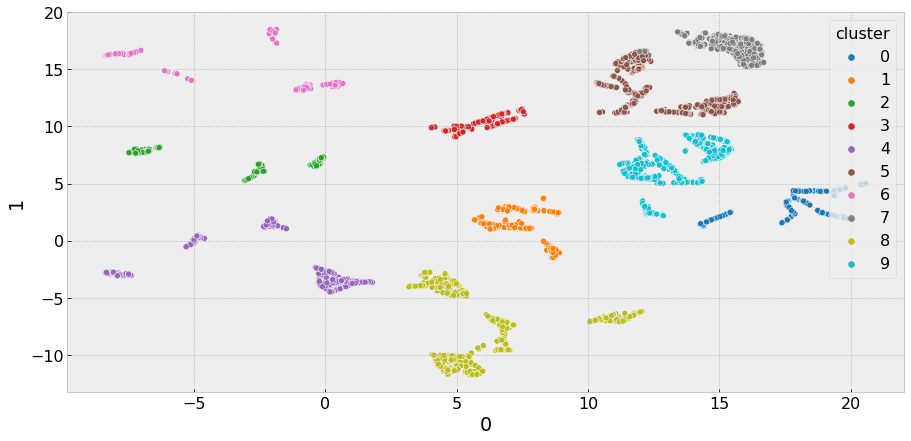

In [30]:
df_plot = X.copy()
df_plot['cluster'] = labels
sns.scatterplot(data = df_plot, x = 0, y = 1, hue = 'cluster', palette = 'tab10')

## 8.2 Hierarchical Clustering

In [31]:
n_clusters = 10

# Model
hc_model = hc.linkage(X, 'ward')

# Training & redict
labels = hc.fcluster(hc_model, n_clusters, criterion = 'maxclust')

# Validation
print('SS: {}'.format(silhouette_score(X, labels, metric='euclidean')))

SS: 0.5414782166481018


<AxesSubplot:xlabel='0', ylabel='1'>

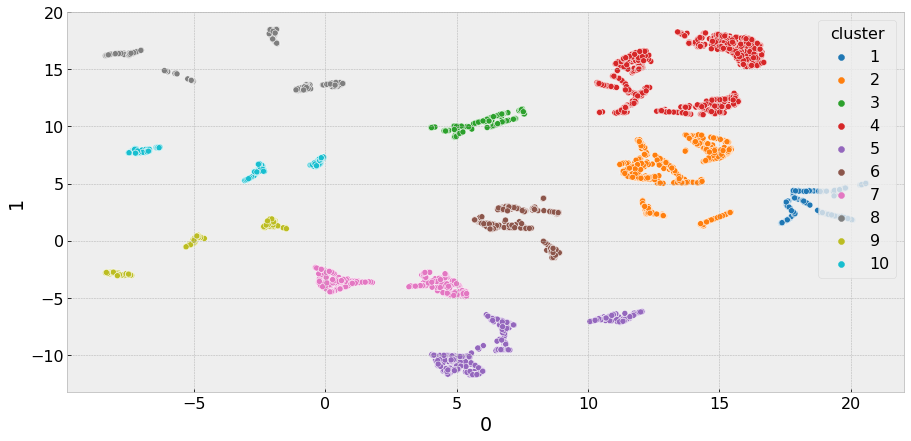

In [32]:
df_plot = X.copy()
df_plot['cluster'] = labels
sns.scatterplot(data = df_plot, x = 0, y = 1, hue = 'cluster', palette = 'tab10')

## 8.3 Modelo final

Hierarchical clustering sobre espaço do UMAP

# 9 Análise do cluster

In [33]:
df_plot = df7.copy()
df_plot['cluster'] = labels

## 9.1 Inspeção visual

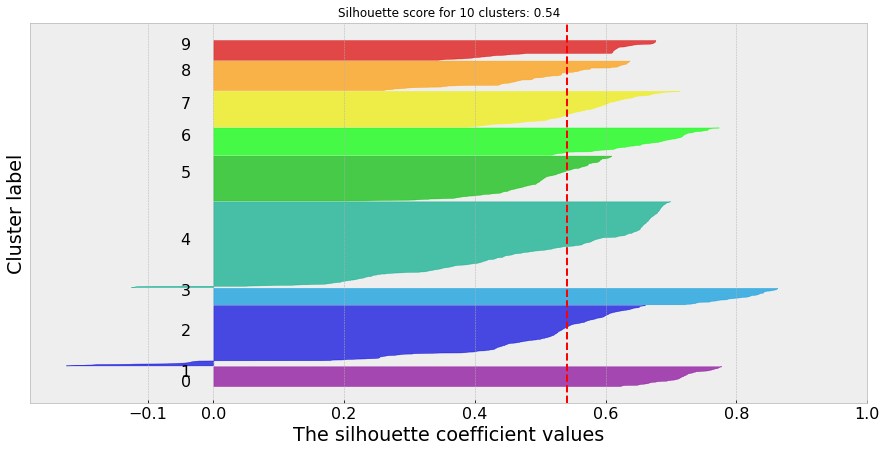

In [58]:
fig, ax = plt.subplots()
silhouette_plot(X, labels, ax)
plt.savefig('../reports/figures/silhouette.png', facecolor = 'w')

### 9.1.1 2 features

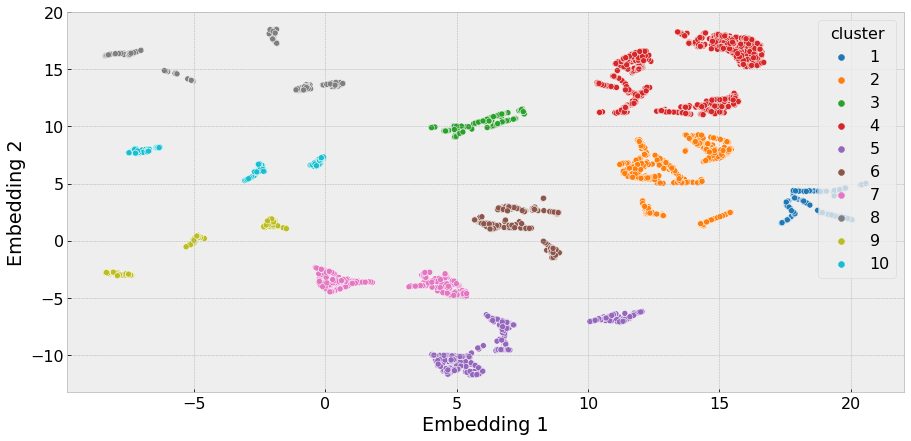

In [56]:
sns.scatterplot(data = df_plot, x = 0, y = 1, hue = 'cluster', palette = 'tab10')
plt.xlabel('Embedding 1')
plt.ylabel('Embedding 2')
plt.savefig('../reports/figures/embedding.png', facecolor = 'w')

## 9.2 Recuperar dados originais

In [38]:
df9 = df4.copy()
df9['cluster'] = labels

## 9.3 Descrição do perfil

In [39]:
# Número de clientes
df_cluster = df9[['cluster', 'customer_id']].groupby('cluster').count().reset_index()
df_cluster['customer%'] = 100*df_cluster['customer_id']/df_cluster['customer_id'].sum()

# Receita média
aux = df9[['cluster', 'revenue']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(aux, how='left', on='cluster')

# Receita recorrente
aux = df9[['cluster', 'monthly_revenue']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(aux, how='left', on='cluster')

# Recência média
aux = df9[['cluster', 'recency']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(aux, how='left', on='cluster')

# Número de compras médio
aux = df9[['cluster', 'invoices']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(aux, how='left', on='cluster')

# Número de compras recorrentes
aux = df9[['cluster', 'monthly_invoices']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(aux, how='left', on='cluster')

# Média do ticket médio
aux = df9[['cluster', 'avg_ticket']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(aux, how='left', on='cluster')

# Tempo como cliente
aux = df9[['cluster', 'vintage']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(aux, how='left', on='cluster')

df_cluster

,cluster,customer_id,customer%,revenue,monthly_revenue,recency,invoices,monthly_invoices,avg_ticket,vintage
0,1,237,5.473441,708.897257,78.839059,116.658228,2.000000,0.221402,354.448629,9.101266
1,2,722,16.674365,1896.561648,214.582308,51.702216,5.027701,0.575564,369.423827,8.695291
2,3,197,4.549654,611.001320,51.191451,155.147208,2.000000,0.166223,305.500660,12.096447
3,4,1027,23.718245,5380.594607,431.844195,46.562804,10.149951,0.816834,429.393181,12.245375
4,5,538,12.424942,830.297825,454.284441,18.535316,2.113383,1.225372,340.689716,1.776952
5,6,327,7.551963,1103.024954,215.954140,45.244648,3.247706,0.643156,345.554573,5.146789
6,7,428,9.884527,439.679159,184.333602,58.953271,1.002336,0.423676,438.843925,2.464953
7,8,353,8.152425,308.067054,29.055771,310.787535,1.000000,0.093823,308.067054,10.892351
8,9,236,5.450346,608.151780,113.692455,137.135593,1.008475,0.205917,495.393305,5.033898
9,10,265,6.120092,314.197962,37.925804,238.400000,1.000000,0.120836,314.197962,8.452830


*Cluster 4 (candidato ao programa Insider):*
- Número de clientes: 1.027 (23,7% da base de clientes)
- Recência: 46 dias
- Histórico de compras: 10 compras
- Média de compras: 0,8 compra/mês
- Clientes há: 12 meses
- Receita histórica: $5.380,59

- Receita média: $431,84/mês

- Ticket médio: $429,39

*Cluster 5:*
- Número de clientes: 538 (12,4% da base de clientes)
- Recência: 18 dias
- Histórico de compras: 2 compras
- Média de compras: 1 compra/mês
- Clientes há: 2 meses
- Receita histórica: $830,30

- Receita média: $454,28/mês

- Ticket médio: $340,69

# 10 Análise exploratória de dados

## Data checkpoint

In [40]:
df10 = df9.copy()

In [41]:
df10.to_csv('../data/interim/c5_df10.csv', index = False)

In [44]:
df10 = pd.read_csv('../data/interim/c5_df10.csv')

## 10.1 Mapa de hipóteses

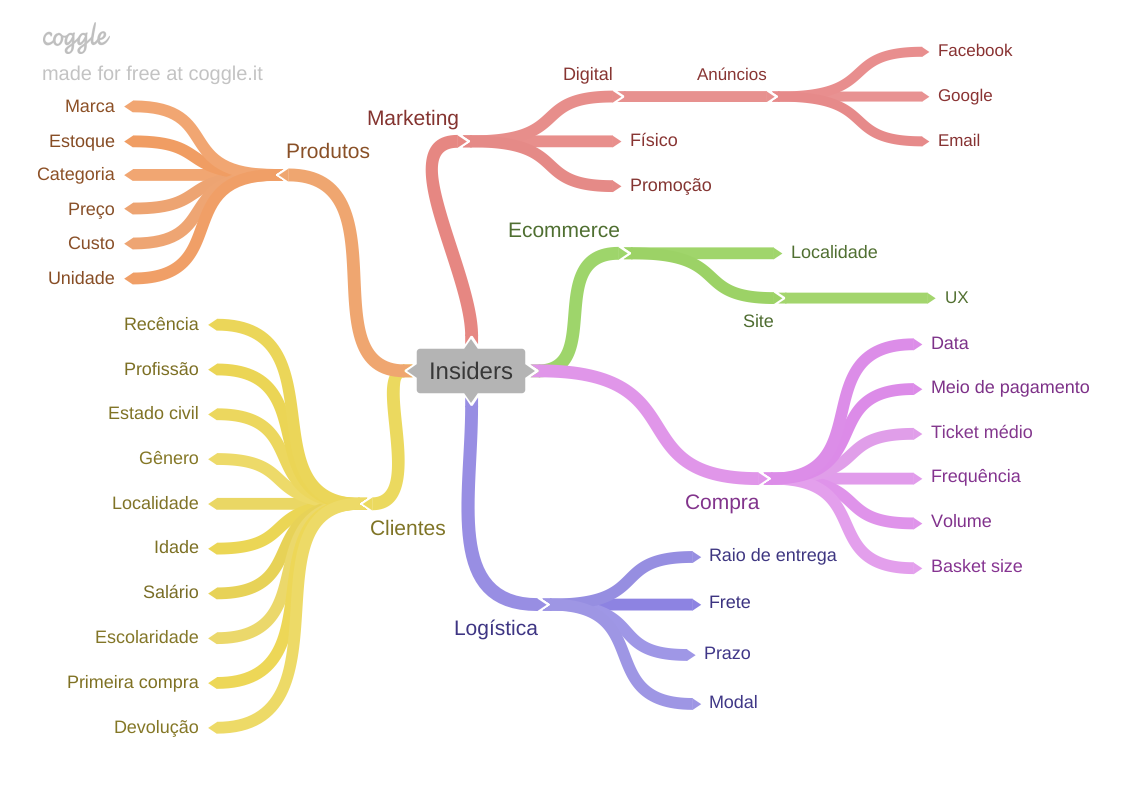

In [31]:
Image('../reports/figures/HypothesisMindMap.png')

## 10.2 Criação das hipóteses

### 10.1 Compra

**1**. 80% dos clientes Insider usam cartão de crédito como forma de pagamento.

**2**. Ticket médio dos clientes Insider é 30% maior que dos demais clientes.

**3**. Basket size dos clientes Insider possui 5% mais produtos.

**4**. A receita mensal dos clientes Insider é 10% da receita global.

**5**. O volume de devoluções dos clientes Insider é menor que a média global dos clientes.

### 10.2 Produto

**1**. Clientes Insider compram uma maior variedade de produtos.

**2**. 30% das compras de clientes Insider são no setor de eletrônicos.

**3**. Clientes Insider compram produtos 5% mais baratos em média.

**4**. A idade média dos produtos comprados pelos clientes Insider é menor que 15 dias.

**5**. 40% dos produtos comprados pelos clientes Insider são de alto custo.

### 10.3 Cliente

**1**. 50% dos clientes Insider são solteiros.

**2**. 10% dos clientes Insider possuem mais de 35 anos de idade.

**3**. 60% dos clientes Insider possuem renda de 3 salários mínimos.

**4**. 80% dos clientes Insider moram no Reino Unido.

**5**. 70% dos clientes Insider são clientes há mais de 6 meses.

## 10.3 Prioridade das hipóteses

Possível  responder

**1**. Ticket médio dos clientes Insider é 30% maior que dos demais clientes.

**2**. Basket size dos clientes Insider possui 5% mais produtos.

**3**. A receita mensal dos clientes Insider é 10% da receita global.

**4**. O volume de devoluções dos clientes Insider é menor que a média global dos clientes.

**5**. Clientes Insider compram uma maior variedade de produtos.

**6**. Clientes Insider compram produtos 5% mais baratos em média.

**7**. 80% dos clientes Insider moram no Reino Unido.

**8**. 70% dos clientes Insider são clientes há mais de 6 meses.

Faltam dados:

- 80% dos clientes Insider usam cartão de crédito como forma de pagamento.

- 30% das compras de clientes Insider são no setor de eletrônicos.

- A idade média dos produtos comprados pelos clientes Insider é menor que 15 dias.

- 40% dos produtos comprados pelos clientes Insider são de alto custo.

- 50% dos clientes Insider são solteiros.

- 10% dos clientes Insider possuem mais de 35 anos de idade.

- 60% dos clientes Insider possuem renda de 3 salários mínimos.

## 10.4 Validação das hipóteses

### 10.4.1 Ticket médio dos clientes Insider é 30% maior que dos demais clientes.
**Falso:** o ticket médio dos clientes Insider é 13% menor que do grupo 9 e 2% menor que do grupo 7.

<AxesSubplot:xlabel='cluster', ylabel='avg_ticket'>

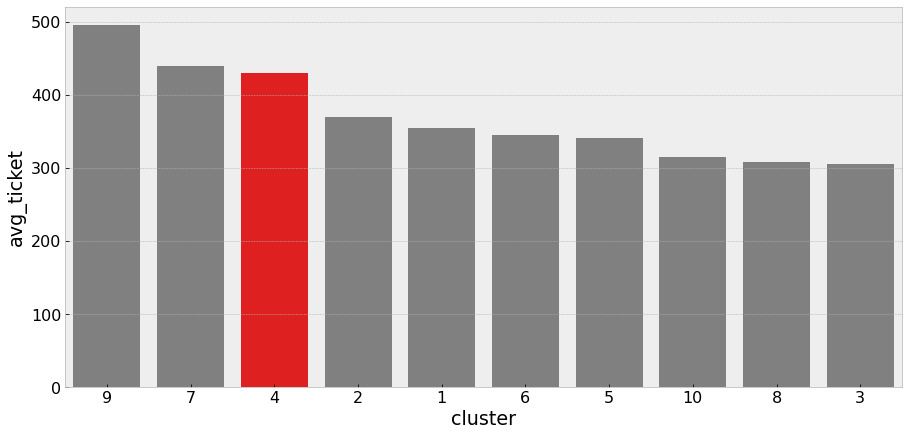

In [39]:
aux = df10[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
aux.sort_values('avg_ticket', ascending = False, inplace = True)
aux['color'] = aux['cluster'].apply(lambda x: 'red' if x == 4 else 'gray')
aux['cluster'] = aux['cluster'].astype(str)
sns.barplot(data = aux, x = 'cluster', y = 'avg_ticket', palette = aux['color'])

In [52]:
insider = aux.loc[aux['cluster'] == '4', 'avg_ticket'].iloc[0]
other = aux.loc[aux['cluster'] == '9', 'avg_ticket'].iloc[0]
diff = 100*(other-insider)/other
diff

13.32277279510721

In [53]:
insider = aux.loc[aux['cluster'] == '4', 'avg_ticket'].iloc[0]
other = aux.loc[aux['cluster'] == '7', 'avg_ticket'].iloc[0]
diff = 100*(other-insider)/other
diff

2.1535548481115194

### 10.4.2 Basket size dos clientes Insider possui 5% mais produtos.
**Falso:** o basket size médio dos clientes Insider é 20% menor que do grupo 9 e 9% menor que do grupo 7.

<AxesSubplot:xlabel='cluster', ylabel='basket_size'>

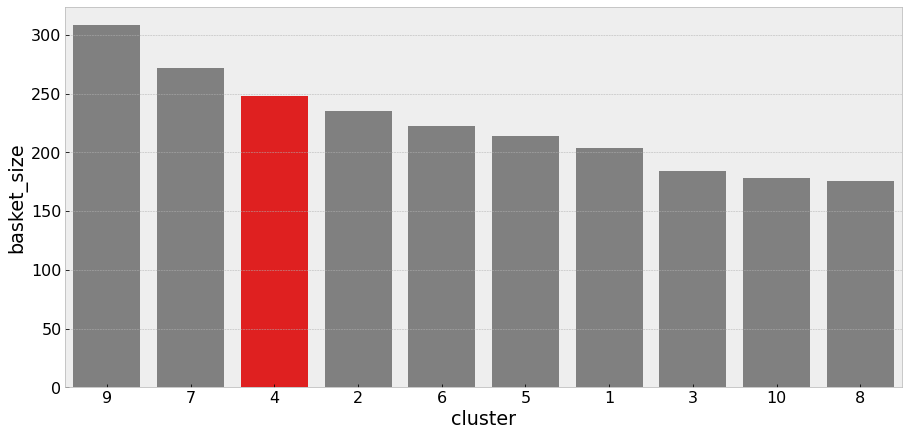

In [54]:
aux = df10[['basket_size', 'cluster']].groupby('cluster').mean().reset_index()
aux.sort_values('basket_size', ascending = False, inplace = True)
aux['color'] = aux['cluster'].apply(lambda x: 'red' if x == 4 else 'gray')
aux['cluster'] = aux['cluster'].astype(str)
sns.barplot(data = aux, x = 'cluster', y = 'basket_size', palette = aux['color'])

In [55]:
insider = aux.loc[aux['cluster'] == '4', 'basket_size'].iloc[0]
other = aux.loc[aux['cluster'] == '9', 'basket_size'].iloc[0]
diff = 100*(other-insider)/other
diff

19.61590842251452

In [56]:
insider = aux.loc[aux['cluster'] == '4', 'basket_size'].iloc[0]
other = aux.loc[aux['cluster'] == '7', 'basket_size'].iloc[0]
diff = 100*(other-insider)/other
diff

8.895490796953176

### 10.4.3 A receita mensal dos clientes Insider é 10% da receita global.
**Verdadeiro:** a receita mensal dos Insider é 42% da receita global.

In [62]:
total = df10['monthly_revenue'].sum()
insider = df10.loc[df10['cluster'] == 4, 'monthly_revenue'].sum()
print('Receita mensal total: $ {:,.2f}'.format(total))
print('Receita mensal Insider: $ {:,.2f} - {:.1f}% do total'.format(insider, 100*insider/total))

Receita mensal total: $ 1,068,257.25
Receita mensal Insider: $ 443,503.99 - 41.5% do total


### 10.4.4 O volume de devoluções dos clientes Insider é menor que a média global dos clientes.
**Verdadeiro:** 59% das devoluções vêm dos clientes Insider.

In [74]:
total = df10['invoices_return'].mean()
insider = df10.loc[df10['cluster'] == 4, 'invoices_return'].mean()
print('Média de devoluções global: {:.1f}'.format(total))
print('Média de devoluções Insider: {:.1f} - {:.1f}% do total'.format(insider, 100*insider/total))

Média de devoluções global: 0.8
Média de devoluções Insider: 1.9 - 248.0% do total


In [73]:
total = df10['invoices_return'].sum()
insider = df10.loc[df10['cluster'] == 4, 'invoices_return'].sum()
print('Número de devoluções total: {:.1f}'.format(total))
print('Número de devoluções Insider: {:.1f} - {:.1f}% do total'.format(insider, 100*insider/total))

Número de devoluções total: 3347.0
Número de devoluções Insider: 1969.0 - 58.8% do total


### 10.4.5 Clientes Insider compram uma maior variedade de produtos.
**Verdadeiro:** a variedade de produtos comprados pelos clientes Insider é 1,6x maior que dos clientes do grupo 2.

<AxesSubplot:xlabel='cluster', ylabel='product_variety'>

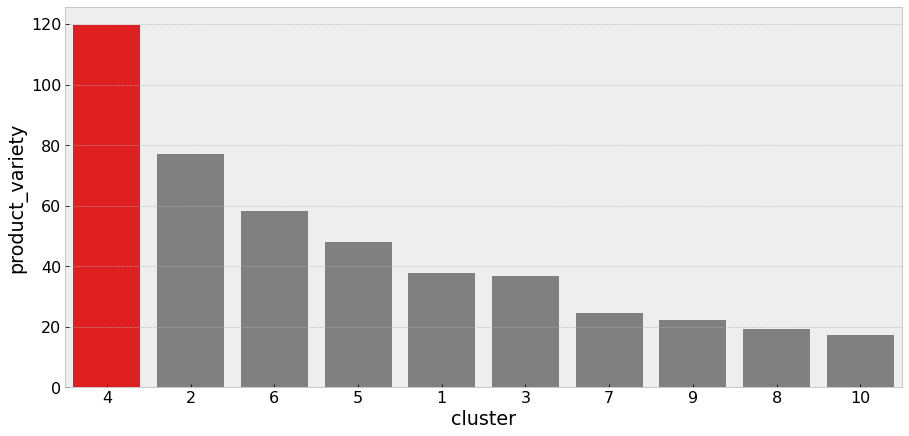

In [76]:
aux = df10[['product_variety', 'cluster']].groupby('cluster').mean().reset_index()
aux.sort_values('product_variety', ascending = False, inplace = True)
aux['color'] = aux['cluster'].apply(lambda x: 'red' if x == 4 else 'gray')
aux['cluster'] = aux['cluster'].astype(str)
sns.barplot(data = aux, x = 'cluster', y = 'product_variety', palette = aux['color'])

In [79]:
insider = aux.loc[aux['cluster'] == '4', 'product_variety'].iloc[0]
other = aux.loc[aux['cluster'] == '2', 'product_variety'].iloc[0]
diff = insider/other
diff

1.5535294964567892

### 10.4.6 Clientes Insider compram produtos 5% mais baratos em média.
**Verdadeiro:** clientes Insider compram produtos em média 13% mais baratos que a média geral.

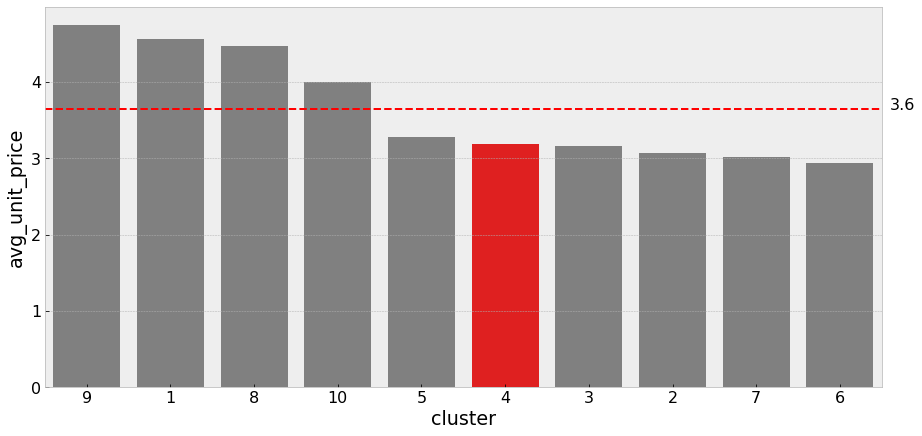

In [118]:
aux = df10[['avg_unit_price', 'cluster']].groupby('cluster').mean().reset_index()
aux.sort_values('avg_unit_price', ascending = False, inplace = True)
aux['color'] = aux['cluster'].apply(lambda x: 'red' if x == 4 else 'gray')
aux['cluster'] = aux['cluster'].astype(str)
ax = sns.barplot(data = aux, x = 'cluster', y = 'avg_unit_price', palette = aux['color'])
global_avg = aux['avg_unit_price'].mean()

ax.axhline(global_avg, color = 'r', ls = '--')
ax.text(9.6, global_avg, '{:.1f}'.format(global_avg));

In [119]:
insider = aux.loc[aux['cluster'] == '4', 'avg_unit_price'].iloc[0]
other = aux.loc[aux['cluster'] == '9', 'avg_unit_price'].iloc[0]
diff = 100*(other-insider)/other
diff
print('Preço unitário médio global: {:.1f}'.format(global_avg))
print('Preço unitário médio grupo 9: {:.1f}'.format(other))
print('Preço unitário médio Insider: {:.1f}'.format(insider))
print('\t{:.1f}% menor que o global'.format(100*(1-insider/global_avg)))
print('\t{:.1f}% menor que o grupo 9'.format(100*(1-insider/other)))

Preço unitário médio global: 3.6
Preço unitário médio grupo 9: 4.7
Preço unitário médio Insider: 3.2
	12.6% menor que o global
	32.9% menor que o grupo 9


### 10.4.7 80% dos clientes Insider moram no Reino Unido.
**Verdadeiro:** 90,4% dos clientes Insider moram no Reino Unido.

90.4% dos clientes Insider moram no Reino Unido


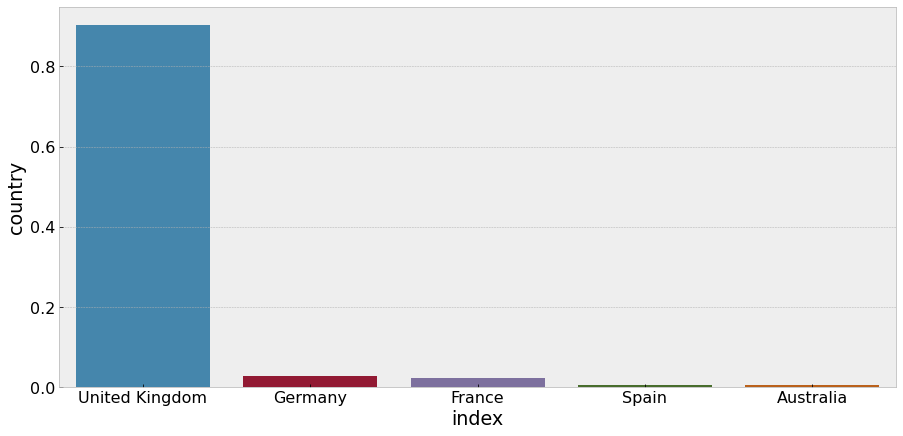

In [141]:
aux = df10.loc[df10['cluster'] == 4, 'country'].value_counts(normalize = True)
aux = pd.DataFrame(aux).reset_index()
sns.barplot(data = aux.head(), x = 'index', y = 'country')
print('{:.1f}% dos clientes Insider moram no Reino Unido'.format(100*aux.loc[0, 'country']))

### 10.4.8 70% dos clientes Insider são clientes há mais de 6 meses.
**Verdadeiro:** todos os clientes Insider são clientes há pelo menos 10 meses.

13    0.493671
12    0.259007
11    0.246349
10    0.000974
Name: vintage, dtype: float64

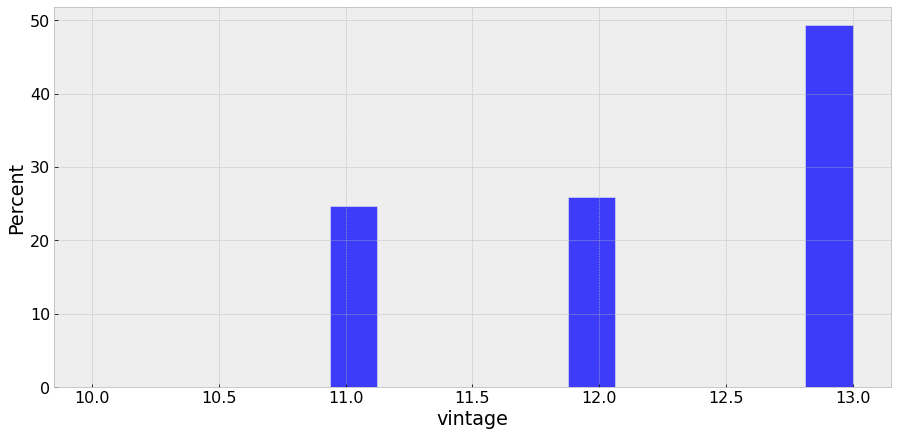

In [150]:
aux = df10.loc[df10['cluster'] == 4, 'vintage']
sns.histplot(aux, stat = 'percent')
aux.value_counts(normalize = True)

## 10.5 Resumo das respostas

In [153]:
tab = [['Hipótese', 'Conclusão'], 
       ['H1', 'Falsa'], 
       ['H2', 'Falsa'], 
       ['H3', 'Verdadeira'], 
       ['H4', 'Verdadeira'], 
       ['H5', 'Verdadeira'], 
       ['H6', 'Verdadeira'], 
       ['H7', 'Verdadeira'], 
       ['H8', 'Verdadeira']
      ]
print(tabulate(tab, headers = 'firstrow'))

Hipótese    Conclusão
----------  -----------
H1          Falsa
H2          Falsa
H3          Verdadeira
H4          Verdadeira
H5          Verdadeira
H6          Verdadeira
H7          Verdadeira
H8          Verdadeira


## 10.6 Respostas para as perguntas de negócios

###  10.6.1 Quem são as pessoas elegíveis para participar do programa Insiders?

In [156]:
df10.loc[df10['name'] == 'insider', 'customer_id'].head()

0     12347
1     12348
8     12356
11    12359
19    12370
Name: customer_id, dtype: int64

###  10.6.2 Quantos clientes farão parte do grupo?

In [157]:
df10.loc[df10['name'] == 'insider', 'customer_id'].nunique()

1027

###  10.6.3 Quais as principais características desses clientes?

*Cluster 4 (candidato ao programa Insider):*
- Número de clientes: 1.027 (23,7% da base de clientes)
- Recência: 46 dias
- Histórico de compras: 10 compras
- Média de compras: 0,8 compra/mês
- Clientes há: 12 meses
- Receita histórica: $5.380,59

- Receita média: $431,84/mês

- Ticket médio: $429,39

###  10.6.4 Qual a porcentagem de contribuição do faturamento vinda do grupo Insider?

In [158]:
total = df10['monthly_revenue'].sum()
insider = df10.loc[df10['cluster'] == 4, 'monthly_revenue'].sum()
print('Receita mensal total: $ {:,.2f}'.format(total))
print('Receita mensal Insider: $ {:,.2f} - {:.1f}% do total'.format(insider, 100*insider/total))

Receita mensal total: $ 1,068,257.25
Receita mensal Insider: $ 443,503.99 - 41.5% do total
